In [18]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
from torchtrainer import img_util, transforms
import imgaug.augmenters as iaa
from pathlib import Path
from functools import partial
import re
import numpy as np
import matplotlib.pyplot as plt
import torch

In [247]:
def name_2_label_map(img_filename):
    '''Maps image names to labels names in the DRIVE dataset
    
    Parameters
    ----------
    img_filename : string
        Filename of an image
        
    Returns
    -------
    label_filename : string
        Filename of the corresponding label image
    '''  
    
    m = re.match('(\d\d)_[training|test]', img_filename)
    index = m.group(1)
    label_filename = index + '_manual1.gif'
    
    return label_filename


root_dir = Path('../../../research/drive/data/DRIVE')
img_dir = root_dir/'images'
label_dir = root_dir/'labels'

# Create functions for using in the dataset creation
img_opener_partial = partial(img_util.pil_img_opener, channel=None)
label_opener_partial = partial(img_util.pil_img_opener, is_label=True)

files = list(img_dir.iterdir())
img_pil = img_opener_partial(files[0])
label_pil = label_opener_partial(label_dir/name_2_label_map(files[0].stem))

#img_pil = img_pil.convert('L')

In [277]:
img, label = transforms.TransfToNumpy()(img_pil, label_pil)

In [242]:
ctnp = transforms(to='numpy')
img = ctnp(img_pil)

In [260]:
img.

AttributeError: 'list' object has no attribute 'shape'

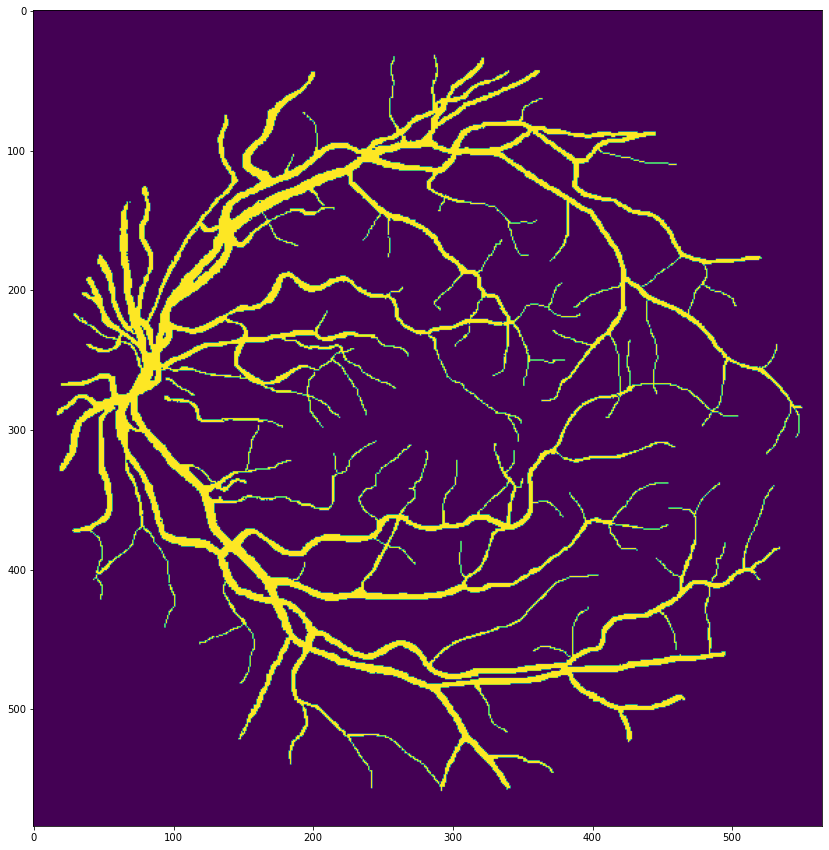

In [279]:
plt.figure(figsize=[15, 15])
plt.imshow(label)

In [ ]:
weight = np.random.rand(img_pil.height, img_pil.width)
weight_pil = Image.fromarray(weight/weight.max())

#img, label, weight = _test_transforms(img_pil, label_pil, weight_pil)

In [16]:
import imgaug as ia

q = ia.SegmentationMapsOnImage(np.zeros((10,10), dtype=np.uint8), shape=(3, 10,10, 3))

In [234]:
class test:
    
    @classmethod
    def imprime(x):
        print(x)
        
    def imprime2(self, x):
        self.imprime(x)

In [235]:
q = test()

In [236]:
q.imprime(5)

5
